# Geoacoustic Parameter Estimation using Bayesian Optimization with a Gaussian Process Surrogate Model

William Jenkins | Scripps Institution of Oceanography | wjenkins@ucsd.edu

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

sys.path.insert(0, '/Users/williamjenkins/Research/Code/TritonOA/')

from tritonoa.io import read_ssp
from tritonoa.kraken import KRAKENModelConfiguration, run_kraken
import tritonoa.plotting as plotting
from tritonoa.sp import beamformer, normalize_pressure, added_wng, snrdb_to_sigma
from tritonoa.core import Top, Bottom, SoundSpeedProfile, Layer, Source, Receiver

## 1&nbsp;&nbsp;Simulate the Source

In this section, an acoustic pressure field is generated to simulate data that is recorded on an acoustic array.  These simulated data comprise the observed data to which replica data will be compared using the Bartlett processor.

### 1.1&nbsp;&nbsp;View TL given source depth over depth and range.

Before proceeding, let's look at what the transmission loss would look like for the given environment.

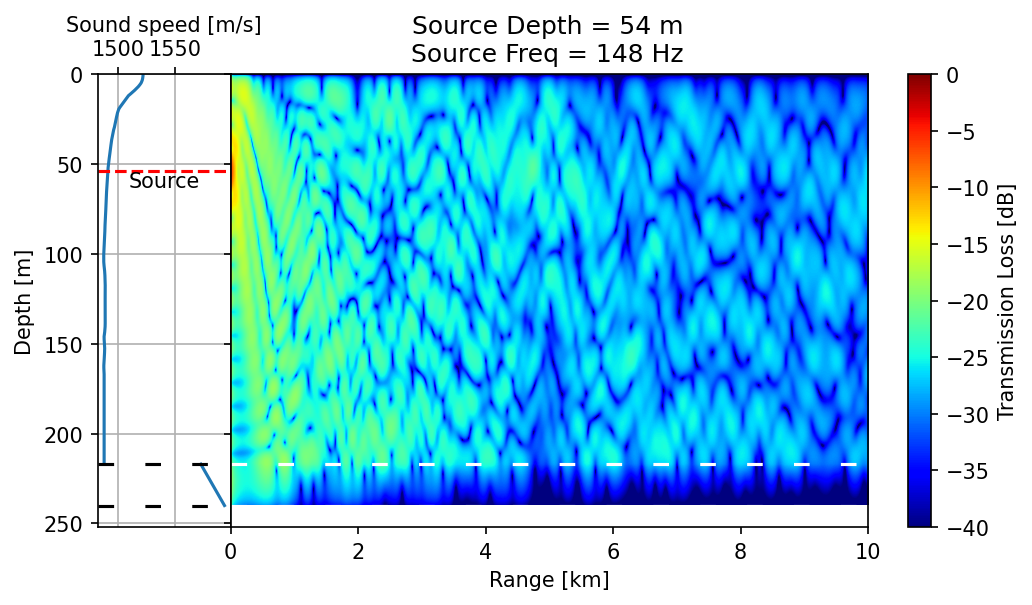

In [2]:
profile = "SWELLEX"
title = profile

fname = Path("/Users/williamjenkins/Research/Projects/BOGP/Data/SWELLEX96/CTD/i9606.prn")
z_data, c_data, _ = read_ssp(fname, 0, 3, header=None)
z_data = np.append(z_data, 217)
c_data = np.append(c_data, c_data[-1])

top = Top()

layerdata = [
    {
        "z": z_data,
        "c_p": c_data,
        "rho": 1
    },
    {
        "z": [217, 240],
        "c_p": [1572.37, 1593.02],
        "rho": 1.8,
        "a_p": 0.3
    },
    {
        "z": [240, 1040],
        "c_p": [1881, 3245.8],
        "rho": 2.1,
        "a_p": 0.09
    }
]

layers = [Layer(SoundSpeedProfile(**kwargs)) for kwargs in layerdata]

bottom = Bottom(opt="A", z=layers[-1].z_max+1, c_p=5200, rho=2.7, a_p=0.03)

source = Source(54)
zvec = np.arange(0, layers[1].z_max, 0.5)
dr = 0.5 * 1e-3
rvec = np.arange(0, 10 + dr, dr)
receiver = Receiver(zvec, rvec)

freq = 148
clow = 0
chigh = 1600

kmodel = KRAKENModelConfiguration(
    title,
    freq,
    layers,
    top,
    bottom,
    source,
    receiver,
    clow=clow,
    chigh=chigh,
    tmpdir="tmp"
)

model = "KRAKENC"
kmodel.run(fldflag=True, model=model)
p_rec = kmodel.modes.p
p_rec_norm = normalize_pressure(kmodel.modes.p, log=True)


fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"width_ratios": [1, 6], "wspace": 0}, figsize=(8, 4), dpi=150)

z = np.array([])
c = np.array([])
b = np.array([])
for layer in layers[:-1]:
    z = np.concatenate((z, layer.ssp.z))
    c = np.concatenate((c, layer.ssp.c_p))
    b = np.concatenate((b, [layer.z_max]))

ax = plotting.plot_SSP(
    z,
    c,
    boundaries=b,
    xlabel="Sound speed [m/s]",
    ylabel="Depth [m]",
    ax=axs[0]
)
ax.axhline(kmodel.source.z, c='r', linestyle='--')
ax.text(np.mean(ax.get_xlim()), kmodel.source.z.item(), f"Source", ha="center", va="top")

ax = plotting.plot_TL_2d(
    p_rec_norm,
    z=kmodel.receiver.z,
    r=np.concatenate((np.array([0]), kmodel.receiver.r)),
    boundaries=b,
    xlabel="Range [km]",
    clabel="Transmission Loss [dB]",
    vmin=-40,
    ax=axs[1]
)
fig.suptitle(f"Source Depth = {kmodel.source.z.item()} m\nSource Freq = {freq} Hz")
# fig.savefig("../../Reports/Figures/TL_SWELLEX_148Hz_54m_8km.png", dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

### 1.2&nbsp;&nbsp;Set the parameters of the source.

Now that we have an understanding of what the acoustic propagation looks like for this environment, let's proceed with simulating the source.  First we will set source location and geoacoustic parameters of the environment.

In [81]:
depth_true = 54
range_true = 4.4

# ======================================================================
# ---------------------- Miscellaneous Parameters ----------------------
fixedparams = dict()
fixedparams["title"] = "SWELLEX96"
fixedparams["tmpdir"] = "tmp"
fixedparams["model"] = "KRAKENC"

# --------------------------- Top Parameters ---------------------------
# None to configure.

# -------------------------- Layer Parameters --------------------------
fixedparams["layerdata"] = [
    {
        "z": z_data,
        "c_p": c_data,
        "rho": 1
    },
    {
        "z": [217, 240],
        "c_p": [1572.37, 1593.02],
        "rho": 1.8,
        "a_p": 0.3
    },
    {
        "z": [240, 1040],
        "c_p": [1881, 3245.8],
        "rho": 2.1,
        "a_p": 0.09
    }
]

# ------------------------- Bottom Parameters --------------------------
# Note: By default, bottom depth is pulled from layer data
fixedparams["bot_opt"] = "A"
fixedparams["bot_c_p"] = 5200
fixedparams["bot_rho"] = 2.7
fixedparams["bot_a_p"] = 0.03

# ------------------------- Source Parameters --------------------------
fixedparams["src_z"] = depth_true

# ------------------------ Receiver Parameters ------------------------
N_elements = 64
fixedparams["rec_z"] = np.linspace(94.125, 212.25, N_elements)
fixedparams["rec_r"] = range_true
fixedparams["SNR"] = 20


# ------------------------ Freq/Mode Parameters ------------------------
fixedparams["freq"] = freq
fixedparams["clow"] = 0
fixedparams["chigh"] = 1600

### 1.3&nbsp;&nbsp;Calculate received pressure field.

Using the environmental and localization parameters set above, we compute the received pressure field at the receiver array for the simulated source.

Noiseless observation

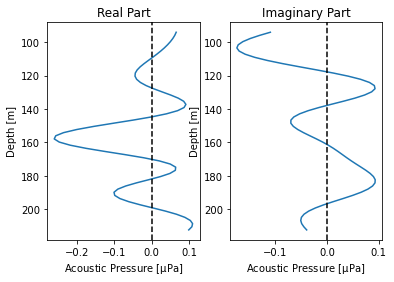

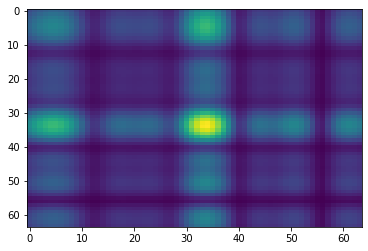

In [82]:
p_rec = run_kraken(fixedparams)
p_rec = p_rec / np.linalg.norm(p_rec)

# Normalize pressure field
p_rec_norm = normalize_pressure(p_rec, log=True)

# Calculate covariance matrix
K = p_rec @ p_rec.conj().T / N_elements

fig = plt.figure(figsize=(6, 4))

plt.subplot(1, 2, 1)
plt.plot(np.real(p_rec), fixedparams["rec_z"])
plt.gca().invert_yaxis()
plt.axvline(0, c="k", linestyle="--")
plt.xlabel(r"Acoustic Pressure [$\mathrm{\mu}$Pa]")
plt.ylabel("Depth [m]")
plt.title("Real Part")

plt.subplot(1, 2, 2)
plt.plot(np.imag(p_rec), fixedparams["rec_z"])
plt.gca().invert_yaxis()
plt.axvline(0, c="k", linestyle="--")
plt.xlabel(r"Acoustic Pressure [$\mathrm{\mu}$Pa]")
plt.ylabel("Depth [m]")
plt.title("Imaginary Part")

plt.show()

# fig.savefig("../../Reports/Figures/swellex_rx_pressure.png", dpi=300, facecolor="white", bbox_inches="tight")

fig = plt.figure(figsize=(6, 4))
plt.imshow(abs(K), aspect="auto")
plt.show()

Noisy observation

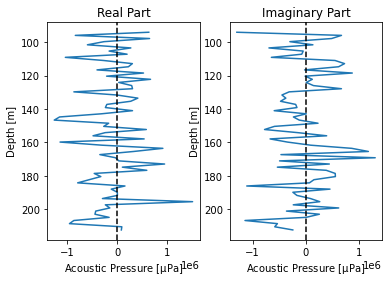

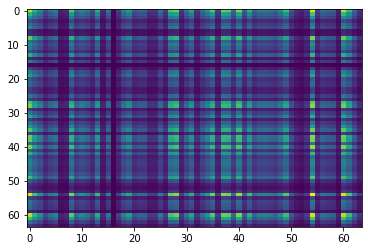

In [83]:
p_rec = run_kraken(fixedparams)
p_rec = p_rec / np.linalg.norm(p_rec)
sigma = snrdb_to_sigma(3)
noise = added_wng(p_rec.shape, sigma, cmplx=np.iscomplexobj(p_rec), seed=2009)
p_rec += noise

# Normalize pressure field
p_rec_norm = normalize_pressure(p_rec, log=True)

# Calculate covariance matrix
K = p_rec @ p_rec.conj().T / N_elements

fig = plt.figure(figsize=(6, 4))

plt.subplot(1, 2, 1)
plt.plot(np.real(p_rec)*1e6, fixedparams["rec_z"])
plt.gca().invert_yaxis()
plt.axvline(0, c="k", linestyle="--")
plt.xlabel(r"Acoustic Pressure [$\mathrm{\mu}$Pa]")
plt.ylabel("Depth [m]")
plt.title("Real Part")

plt.subplot(1, 2, 2)
plt.plot(np.imag(p_rec)*1e6, fixedparams["rec_z"])
plt.gca().invert_yaxis()
plt.axvline(0, c="k", linestyle="--")
plt.xlabel(r"Acoustic Pressure [$\mathrm{\mu}$Pa]")
plt.ylabel("Depth [m]")
plt.title("Imaginary Part")

plt.show()

# fig.savefig("../../Reports/Figures/swellex_rx_pressure.png", dpi=300, facecolor="white", bbox_inches="tight")

fig = plt.figure(figsize=(6, 4))
plt.imshow(abs(K), aspect="auto")
plt.show()

## 2&nbsp;&nbsp;Optimization

In this section, we will attempt to localize the acoustic source and to estimate certain geoacoustic parameters which may be unknown.  Various methods are presented here, including grid search (matched field processing, or MFP), Bayesian optimization using a Gaussian process surrogate model (BOGP), and others.  A simple 2-D case is presented as a tutorial to demonstrate the BOGP method.

### 2.1&nbsp;&nbsp;Define search space

The first step is to define the parameter search space.  The source localization and geoacoustic parameters are split into two dictionaries: one for those parameters which are known and therefore fixed; and a second for those parameters which we seek to estimate.  These searchable parameters as ranges which will be sampled in the course of the various methods presented.

In the case of 2-D localization, the only search parameters are the source range and depth.

In [84]:
# ======================================================================
# ========================== FIXED PARAMETERS ==========================
# ======================================================================

# ---------------------- Miscellaneous Parameters ----------------------
fixedparams = dict()
fixedparams["title"] = "SWELLEX96"
fixedparams["tmpdir"] = "tmp"
fixedparams["model"] = "KRAKENC"

# --------------------------- Top Parameters ---------------------------
# None to configure.

# -------------------------- Layer Parameters --------------------------
fixedparams["layerdata"] = [
    {
        "z": z_data,
        "c_p": c_data,
        "rho": 1
    },
    {
        "z": [217, 240],
        "c_p": [1572.37, 1593.02],
        "rho": 1.8,
        "a_p": 0.3
    },
    {
        "z": [240, 1040],
        "c_p": [1881, 3245.8],
        "rho": 2.1,
        "a_p": 0.09
    }
]

# ------------------------- Bottom Parameters --------------------------
# Note: By default, bottom depth is pulled from layer data
fixedparams["bot_opt"] = "A"
fixedparams["bot_c_p"] = 5200.
fixedparams["bot_rho"] = 2.7
fixedparams["bot_a_p"] = 0.03

# ------------------------- Source Parameters --------------------------
fixedparams["src_z"] = depth_true

# ------------------------ Receiver Parameters ------------------------
fixedparams["rec_z"] = np.linspace(94.125, 212.25, 64)
# fixedparams["rec_r"] = range_true
fixedparams["SNR"] = 20


# ------------------------ Freq/Mode Parameters ------------------------
fixedparams["freq"] = freq
fixedparams["clow"] = 0
fixedparams["chigh"] = 1600


# ======================================================================
# ============================ SEARCH SPACE ============================
# ======================================================================
parameters = [
    {
        "name": "rec_r",
        "type": "range",
        "bounds": [3.0, 6.0],
        "value_type": "float"
    },
    # {
    #     "name": "src_z",
    #     "type": "range",
    #     "bounds": [10., 100.],
    #     "value_type": "float"
    # }
]

### 2.2&nbsp;&nbsp;Matched Field Processing

In [85]:
dr = 1 / 1e3
rvec = np.arange(1e-3, 10. + dr, dr)
zvec = np.arange(1., 211., 1)

pbar = tqdm(
    zvec,
    bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}',
    desc="MFP",
    leave=True,
    position=0,
    unit=" step"
)

p_rep = np.zeros((len(zvec), len(rvec), len(fixedparams["rec_z"])))
B_bart = np.zeros((len(zvec), len(rvec)))
# B_mvdr = np.zeros((len(zvec), len(rvec)))
for zz, z in enumerate(pbar):
    p_rep = run_kraken(fixedparams | {"src_z": z, "rec_r": rvec})
    for rr, r in enumerate(rvec):
        B_bart[zz, rr] = beamformer(K, p_rep[:, rr], atype="cbf").item()
        # B_mvdr[zz, rr] = beamformer(K, p_rep[:, rr], atype="MVDR").item()

MFP: 100%|████████████████████| 210/210 [00:41<00:00,  5.03 step/s]


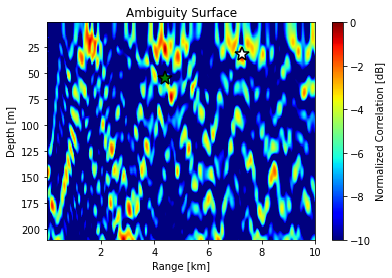

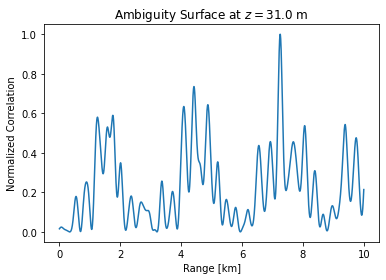

: 

In [86]:
scaler = 1 / np.max(B_bart)
Bn = B_bart * scaler
logBn = 10 * np.log10(Bn)
src_z_ind, src_r_ind = np.unravel_index(np.argmax(logBn), (len(zvec), len(rvec)))

fig = plt.figure(figsize=(6, 4))
plt.imshow(
    logBn,
    aspect="auto",
    extent=[min(rvec), max(rvec), min(zvec), max(zvec)],
    origin="lower",
    vmin=-10, vmax=0, interpolation="none",
    cmap="jet"
)
plt.plot(rvec[src_r_ind], zvec[src_z_ind], 'w*', markersize=15, markeredgewidth=1.5, markeredgecolor="k")
plt.plot(range_true, depth_true, "g*", markersize=15, markeredgewidth=1.5, markeredgecolor="k")
plt.gca().invert_yaxis()
plt.xlabel("Range [km]")
plt.ylabel("Depth [m]")
plt.title("Ambiguity Surface")
plt.colorbar(label="Normalized Correlation [dB]")
plt.show()

fig = plt.figure(figsize=(6, 4))
plt.plot(rvec, Bn[src_z_ind])
plt.xlabel("Range [km]")
plt.ylabel("Normalized Correlation")
plt.title(fr"Ambiguity Surface at $z={zvec[src_z_ind]}$ m")
plt.show()
# fig.savefig("../../Reports/Figures/1D_amb_surf.png", dpi=300, facecolor="white", bbox_inches="tight")

# fig.savefig("../../Reports/Figures/MFP_SWELLEX.png", dpi=150, facecolor="white", bbox_inches="tight")
# fig.savefig("../../Reports/Figures/MFP_SWELLEX_nolocation.png", dpi=150, facecolor="white", bbox_inches="tight")

# Bn = B_mvdr / np.max(B_mvdr)
# logBn = 10 * np.log10(Bn)
# src_z_ind, src_r_ind = np.unravel_index(np.argmax(logBn), (len(zvec), len(rvec)))
# plt.imshow(
#     logBn,
#     aspect="auto",
#     extent=[min(rvec), max(rvec), min(zvec), max(zvec)],
#     origin="lower",
#     vmin=-200, vmax=0, interpolation="none")
# plt.plot(rvec[src_r_ind], zvec[src_z_ind], 'r*')
# plt.gca().invert_yaxis()
# plt.title("MVDR")
# plt.colorbar()
# plt.show()
# print(src_z_ind, src_r_ind)

### Perform Bayesian optimization w/ Gaussian process

Plotting tools

In [83]:
def plot_gp_1d(X, mu, cov, X_train=None, y_train=None, samples: list = list(), ax=None):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.95 * np.sqrt(np.diag(cov))
    if ax is None:
        ax = plt.axes()
    ax.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1, label="Uncertainty")
    ax.plot(X, mu, label="Mean")
    for i, sample in enumerate(samples):
        ax.plot(X, sample, ls='--', label=f"Sample {i+1}")
    if (X_train is not None and y_train is None) or \
        (X_train is None and y_train is not None):
        raise ValueError("'X_train' and 'y_train' must be passed together; one is missing.")
    elif X_train is not None and y_train is not None:
        ax.plot(X_train, y_train, 'rx')
    return ax

Define a kernel

In [84]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    sqdist = np.sum(X1 ** 2, 1).reshape(-1, 1) + np.sum(X2 ** 2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)


def posterior(X_s, X_train, y_train, l=1.0, sigma_f=1.0, sigma_y=1e-7):
    """
    Computes the suffifient statistics of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """

    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-7 * np.eye(len(X_s))
    K = K + K.conj().T / 2 # This enforces symmetry in spite of numerical errors
    K_inv = np.linalg.inv(K)

    mu_s = K_s.T.dot(K_inv).dot(y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    return mu_s, cov_s



In [100]:
from numpy.linalg import cholesky, det, inv
from scipy.linalg import solve_triangular
from scipy.optimize import minimize

def nll_fn(X_train, y_train, noise, naive=True):
    """
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and given
    noise level.

    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        naive: if True use a naive implementation of Eq. (11), if
               False use a numerically more stable implementation.

    Returns:
        Minimization objective.
    """

    y_train = y_train.ravel()

    def nll_naive(theta):
        # Naive implementation of Eq. (11). Works well for the examples 
        # in this article but is numerically less stable compared to 
        # the implementation in nll_stable below.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        # print(f"K PSD: {np.all(np.linalg.eigvals(K) > 0)}")
        return 0.5 * np.log(det(K)) + \
            0.5 * y_train.dot(inv(K).dot(y_train)) + \
            0.5 * len(X_train) * np.log(2 * np.pi)
    
    def nll_stable(theta):
        # Numerically more stable implementation of Eq. (11) as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        # K = (K.conj().T + K) / 2
        # print(f"K PSD: {np.all(np.linalg.eigvals(K) > 0)}")
        L = cholesky(K)

        S1 = solve_triangular(L, y_train, lower=True)
        S2 = solve_triangular(L.T, S1, lower=False)

        return np.sum(np.log(np.diagonal(L))) + \
            0.5 * y_train.dot(S2) + \
            0.5 * len(X_train) * np.log(2 * np.pi)
    
    if naive:
        return nll_naive
    else:
        return nll_stable


Define data & draw samples from the GP

In [101]:
def f(X, scaler=1):
    y = np.zeros_like(X)
    for rr, r in enumerate(X):
        p_rep = run_kraken(fixedparams | {"rec_r": r})
        y[rr] = beamformer(K, p_rep, atype="cbf").item()
    return y * scaler

X = rvec.reshape(-1, 1)
y = f(X, scaler=scaler).reshape(-1, 1)

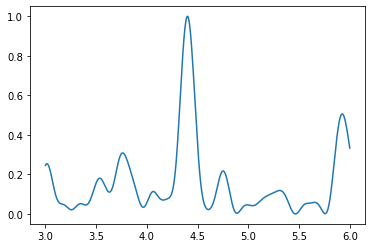

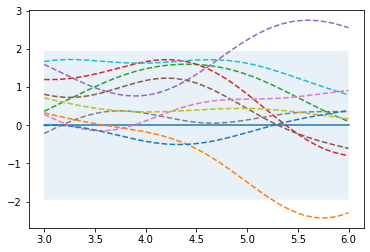

In [102]:
mu = np.zeros_like(X)
cov = kernel(X, X)

rng = np.random.default_rng(2009)
samples = rng.multivariate_normal(mu.ravel(), cov, 10)

fig = plt.figure()
plt.plot(X, y)
plt.show()

fig = plt.figure()
ax = plot_gp_1d(X, mu, cov, samples=samples)
plt.show()

Compute the posterior to make noise-free predictions from training data

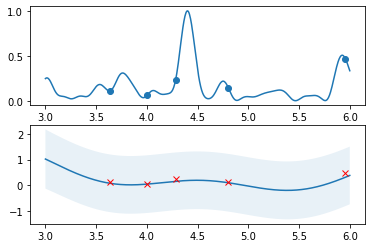

In [103]:
rng = np.random.default_rng(2009)

num_samples = 5
X_train = rng.uniform(X.min(), X.max(), num_samples).reshape(-1, 1)

y_train = f(X_train, scaler)

mu_s, cov_s = posterior(X, X_train, y_train)


fig = plt.figure()
 
ax0 = fig.add_subplot(211)
ax0.plot(X, y)
ax0.scatter(X_train, y_train)

ax1 = fig.add_subplot(212)
ax1 = plot_gp_1d(X, mu_s, cov_s, X_train=X_train, y_train=y_train, ax=ax1)

plt.show()

Number of diagonal elements < 0: 0
Number of root diagonal elements = NaN: 0


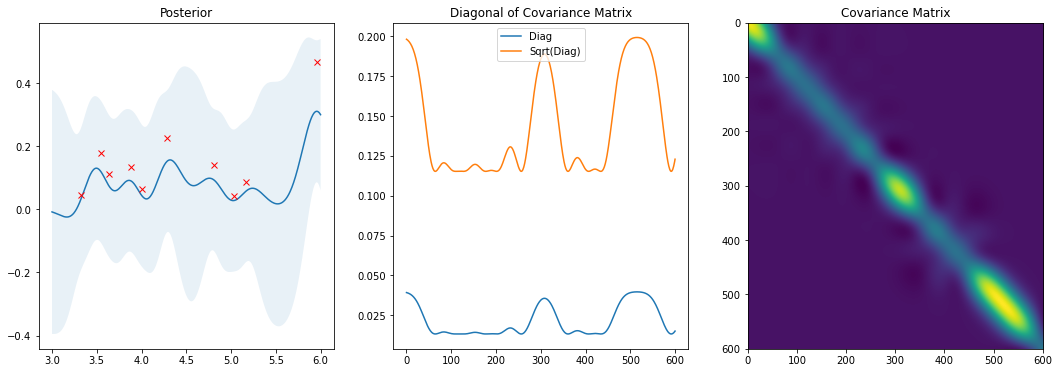

In [104]:
seed = 2009
rng = np.random.default_rng(seed)

num_samples = 10
noise = 1e-5

X_train = rng.uniform(X.min(), X.max(), num_samples).reshape(-1, 1)
y_train = f(X_train, scaler)

res = minimize(
    nll_fn(
        X_train, y_train, noise, naive=False
    ),
    [1, 1],
    bounds=((1e-5, None), (1e-5, None)),
    method="L-BFGS-B"
)

l_opt, sigma_f_opt = res.x

mu_s, cov_s = posterior(X, X_train, y_train, l=l_opt, sigma_f=sigma_f_opt)

print(f"Number of diagonal elements < 0: {len(np.argwhere(np.diag(cov_s) < 0))}")
print(f"Number of root diagonal elements = NaN: {len(np.argwhere(np.isnan(np.sqrt(np.diag(cov_s)))))}")

fig = plt.figure(figsize=(18, 6))

ax0 = fig.add_subplot(131)
ax0 = plot_gp_1d(X, mu_s, cov_s, X_train=X_train, y_train=y_train, ax=ax0)
ax0.set_title("Posterior")

ax1 = fig.add_subplot(132)
ax1.plot(np.diag(cov_s), label="Diag")
ax1.plot(np.sqrt(np.diag(cov_s)), label="Sqrt(Diag)")
ax1.legend()
ax1.set_title("Diagonal of Covariance Matrix")

ax2 = fig.add_subplot(133)
ax2.imshow(cov_s, aspect='auto', interpolation=None)
ax2.set_title("Covariance Matrix")

plt.show()

/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:317: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


Diagonal elements < 0: 0
Root diagonal elements = NaN: 0
Kernel: 0.2**2 * RBF(length_scale=0.0766)


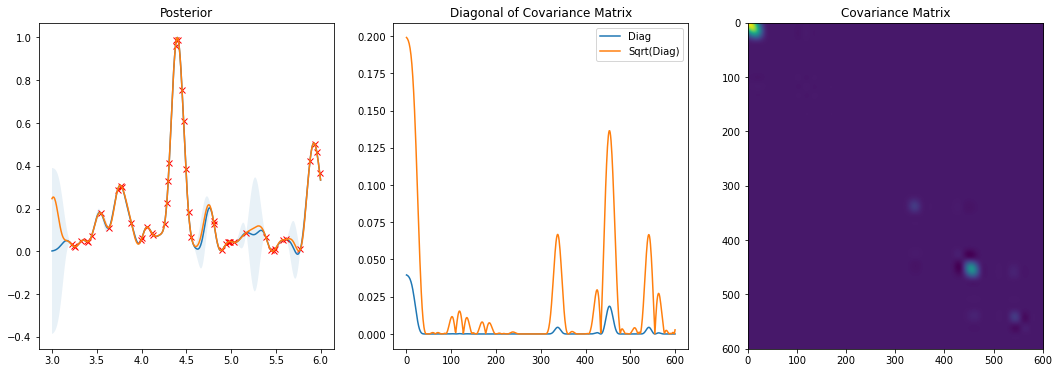

In [118]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern

seed = 2009
rng = np.random.default_rng(seed)

num_samples = 50
# noise = 1e-5

X_train = rng.uniform(X.min(), X.max(), num_samples).reshape(-1, 1)
y_train = f(X_train, scaler)

rbf = ConstantKernel(constant_value=1.0, constant_value_bounds=(0, 10)) * RBF(length_scale=1.0, length_scale_bounds=(0, 10))
# rbf = RBF(length_scale=1.0, length_scale_bounds=(0, 1e5))
# mat52 = ConstantKernel(1.0, constant_value_bounds=(0, 1e5)) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=rbf, random_state=seed)

gpr.fit(X_train, y_train)

mu_s, cov_s = gpr.predict(X, return_cov=True)

print(f"Diagonal elements < 0: {len(np.argwhere(np.diag(cov_s) < 0))}")
print(f"Root diagonal elements = NaN: {len(np.argwhere(np.isnan(np.sqrt(np.diag(cov_s)))))}")
print(f"Kernel: {gpr.kernel_}")

fig = plt.figure(figsize=(18, 6))

ax0 = fig.add_subplot(131)
ax0 = plot_gp_1d(X, mu_s, cov_s, X_train=X_train, y_train=y_train, ax=ax0)
ax0.plot(X, y)
ax0.set_title("Posterior")

ax1 = fig.add_subplot(132)
ax1.plot(np.diag(cov_s), label="Diag")
ax1.plot(np.sqrt(np.diag(cov_s)), label="Sqrt(Diag)")
ax1.legend()
ax1.set_title("Diagonal of Covariance Matrix")

ax2 = fig.add_subplot(133)
ax2.imshow(cov_s, aspect='auto', interpolation=None)
ax2.set_title("Covariance Matrix")

plt.show()

In [158]:
from scipy.stats import norm


def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()


def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()   


def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')


def expected_improvement(X, X_s, y_s, gpr, xi=1e-2):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_s: Sample locations (n x d).
        y_s: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''

    mu, sigma = gpr.predict(X, return_std=True)
    mu_s = gpr.predict(X_s)

    sigma = sigma.reshape(-1, 1)

    # mu_s_opt = np.max(mu_s)
    mu_s_opt = np.max(y_s)

    with np.errstate(divide="warn"):
        improvement = mu - mu_s_opt - xi
        Z = improvement / sigma
        ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.] = 0.
    
    return ei


def get_next_sample(acquisition, X_s, y_s, gpr, bounds, n_restarts=25, seed=None, xi=1e-2):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_s: Sample locations (n x d).
        y_s: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''

    dim = X_s.shape[1]
    min_val = 1
    min_x = None

    def min_obj(X):
        return -acquisition(X.reshape(-1, dim), X_s, y_s, gpr, xi=xi).flatten()

    if seed is None:
        rng = np.random
    else:
        rng = np.random.default_rng(seed)
    
    for x0 in rng.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        print(x0)
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x

    return min_x.reshape(-1, 1)


/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:317: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


[3.63587327]
[4.80436887]
[5.95743513]
[4.2824147]
[4.00543013]
[3.54817289]
[5.03500182]
[3.8855142]
[5.17045075]
[3.32200759]
[4.38011824]
[3.73195079]
[4.81015594]
[5.49134697]
[5.58564881]
[5.3885294]
[3.21878436]
[3.77122903]
[4.9605226]
[4.2984864]
[4.11724355]
[4.55779323]
[4.41100855]
[4.97230483]
[5.48081651]


/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:317: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


[3.63587327]
[4.80436887]
[5.95743513]
[4.2824147]
[4.00543013]
[3.54817289]
[5.03500182]
[3.8855142]
[5.17045075]
[3.32200759]
[4.38011824]
[3.73195079]
[4.81015594]
[5.49134697]
[5.58564881]
[5.3885294]
[3.21878436]
[3.77122903]
[4.9605226]
[4.2984864]
[4.11724355]
[4.55779323]
[4.41100855]
[4.97230483]
[5.48081651]


/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:317: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


[3.63587327]
[4.80436887]
[5.95743513]
[4.2824147]
[4.00543013]
[3.54817289]
[5.03500182]
[3.8855142]
[5.17045075]
[3.32200759]
[4.38011824]
[3.73195079]
[4.81015594]
[5.49134697]
[5.58564881]
[5.3885294]
[3.21878436]
[3.77122903]
[4.9605226]
[4.2984864]
[4.11724355]
[4.55779323]
[4.41100855]
[4.97230483]
[5.48081651]


/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:317: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


[3.63587327]
[4.80436887]
[5.95743513]
[4.2824147]
[4.00543013]
[3.54817289]
[5.03500182]
[3.8855142]
[5.17045075]
[3.32200759]
[4.38011824]
[3.73195079]
[4.81015594]
[5.49134697]
[5.58564881]
[5.3885294]
[3.21878436]
[3.77122903]
[4.9605226]
[4.2984864]
[4.11724355]
[4.55779323]
[4.41100855]
[4.97230483]
[5.48081651]


/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:317: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


[3.63587327]
[4.80436887]
[5.95743513]
[4.2824147]
[4.00543013]
[3.54817289]
[5.03500182]
[3.8855142]
[5.17045075]
[3.32200759]
[4.38011824]
[3.73195079]
[4.81015594]
[5.49134697]
[5.58564881]
[5.3885294]
[3.21878436]
[3.77122903]
[4.9605226]
[4.2984864]
[4.11724355]
[4.55779323]
[4.41100855]
[4.97230483]
[5.48081651]


/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:317: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


[3.63587327]
[4.80436887]
[5.95743513]
[4.2824147]
[4.00543013]
[3.54817289]
[5.03500182]
[3.8855142]
[5.17045075]
[3.32200759]
[4.38011824]
[3.73195079]
[4.81015594]
[5.49134697]
[5.58564881]
[5.3885294]
[3.21878436]
[3.77122903]
[4.9605226]
[4.2984864]
[4.11724355]
[4.55779323]
[4.41100855]
[4.97230483]
[5.48081651]


/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:317: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


[3.63587327]
[4.80436887]
[5.95743513]
[4.2824147]
[4.00543013]
[3.54817289]
[5.03500182]
[3.8855142]
[5.17045075]
[3.32200759]
[4.38011824]
[3.73195079]
[4.81015594]
[5.49134697]
[5.58564881]
[5.3885294]
[3.21878436]
[3.77122903]
[4.9605226]
[4.2984864]
[4.11724355]
[4.55779323]
[4.41100855]
[4.97230483]
[5.48081651]


/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:317: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


[3.63587327]
[4.80436887]
[5.95743513]
[4.2824147]
[4.00543013]
[3.54817289]
[5.03500182]
[3.8855142]
[5.17045075]
[3.32200759]
[4.38011824]
[3.73195079]
[4.81015594]
[5.49134697]
[5.58564881]
[5.3885294]
[3.21878436]
[3.77122903]
[4.9605226]
[4.2984864]
[4.11724355]
[4.55779323]
[4.41100855]
[4.97230483]
[5.48081651]


/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:317: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
/Users/williamjenkins/miniconda3/envs/gp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:317: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


[3.63587327]
[4.80436887]
[5.95743513]
[4.2824147]
[4.00543013]
[3.54817289]
[5.03500182]
[3.8855142]
[5.17045075]
[3.32200759]
[4.38011824]
[3.73195079]
[4.81015594]
[5.49134697]
[5.58564881]
[5.3885294]
[3.21878436]
[3.77122903]
[4.9605226]
[4.2984864]
[4.11724355]
[4.55779323]
[4.41100855]
[4.97230483]
[5.48081651]
[3.63587327]
[4.80436887]
[5.95743513]
[4.2824147]
[4.00543013]
[3.54817289]
[5.03500182]
[3.8855142]
[5.17045075]
[3.32200759]
[4.38011824]
[3.73195079]
[4.81015594]
[5.49134697]
[5.58564881]
[5.3885294]
[3.21878436]
[3.77122903]
[4.9605226]
[4.2984864]
[4.11724355]
[4.55779323]
[4.41100855]
[4.97230483]
[5.48081651]


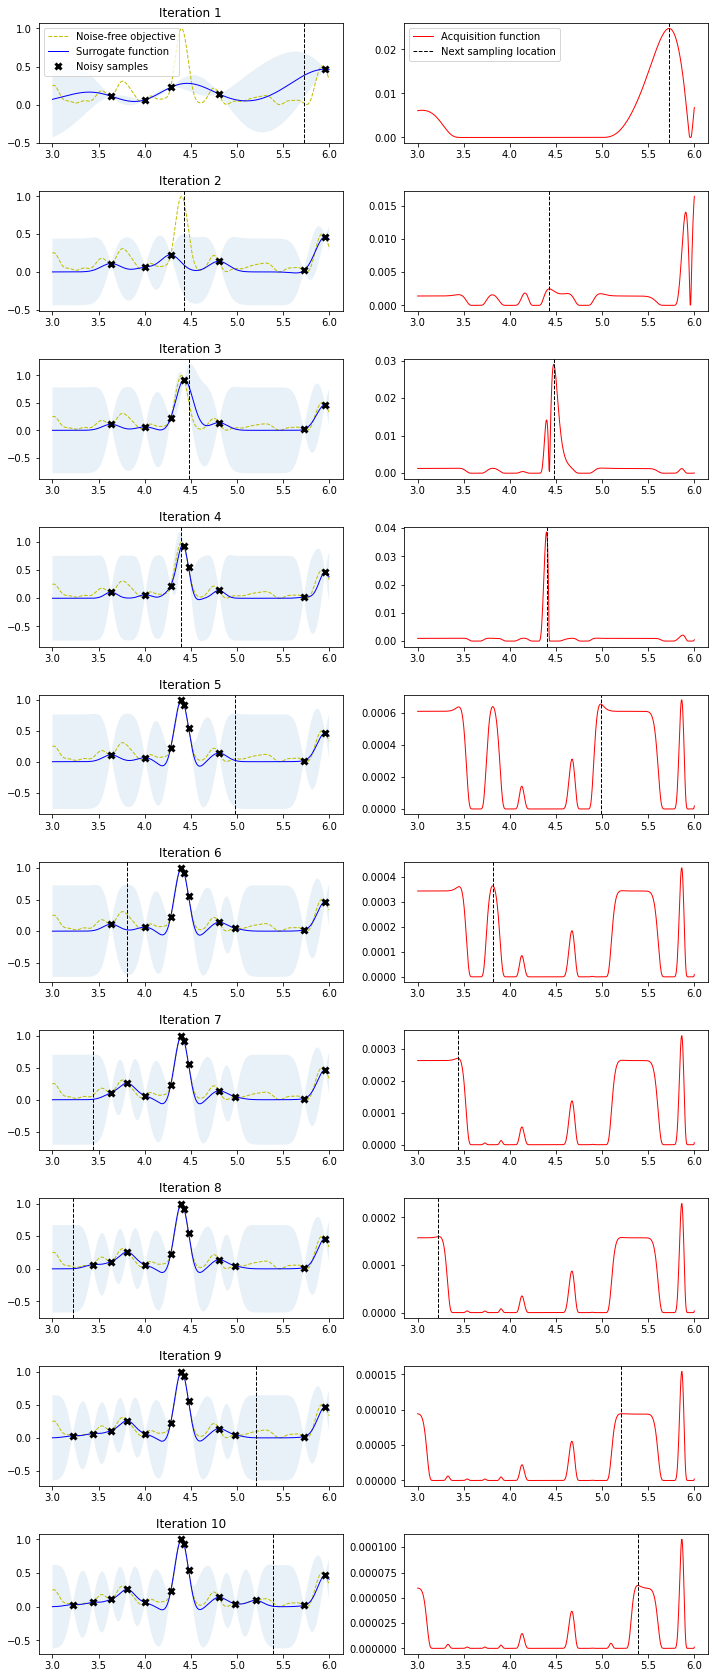

In [159]:
seed = 2009
rng = np.random.default_rng(seed)

num_samples = 5

X_init = rng.uniform(X.min(), X.max(), num_samples).reshape(-1, 1)
y_init = f(X_init, scaler)

X_train = X_init
y_train = y_init

bounds = np.array([[X.min(), X.max()]])
rbf = ConstantKernel(constant_value=1.0, constant_value_bounds=(0, 10)) * RBF(length_scale=1.0, length_scale_bounds=(0, 10))
mat52 = ConstantKernel(constant_value=1.0, constant_value_bounds=(0, 10)) * Matern(length_scale=1.0, nu=2.5, length_scale_bounds=(0, 10))
gpr = GaussianProcessRegressor(kernel=rbf, random_state=seed)

n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    
    gpr.fit(X_train, y_train)

    X_next = get_next_sample(expected_improvement, X_train, y_train, gpr, bounds, seed=seed, xi=0.01)
    # EI = expected_improvement(, X_s, y_s, gpr, xi=1e-2)
    y_next = f(X_next, scaler)

    plt.subplot(n_iter, 2, 2*i + 1)
    plot_approximation(gpr, X, y, X_train, y_train, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2*i + 2)
    plot_acquisition(X, expected_improvement(X, X_train, y_train, gpr), X_next, show_legend=i==0)

    X_train = np.vstack((X_train, X_next))
    y_train = np.vstack((y_train, y_next))


In [156]:
bounds

array([[3., 6.]])